In [1]:
from regen.dataset import DynamicDamageDataset
from regen.model import NCA3DDamageDetection
from regen.trainer import NCA3DTrainer
from regen.utils import plot_voxels, save_weights
import numpy as np

### Load dataset

In [2]:
labels = np.load('../data/ydata_7class.npy')
shapes = np.load('../data/xdata_7class.npy')

In [3]:
dataset = DynamicDamageDataset(shapes, labels, damage_radius_range=(1, 3), damage_types=["sphere", "cube", "random"], random_proportion_range=(0.1, 0.2), fixed_damage=False, augment_rotations=False, return_damage_mask=True, seed=None, filter_label=3)

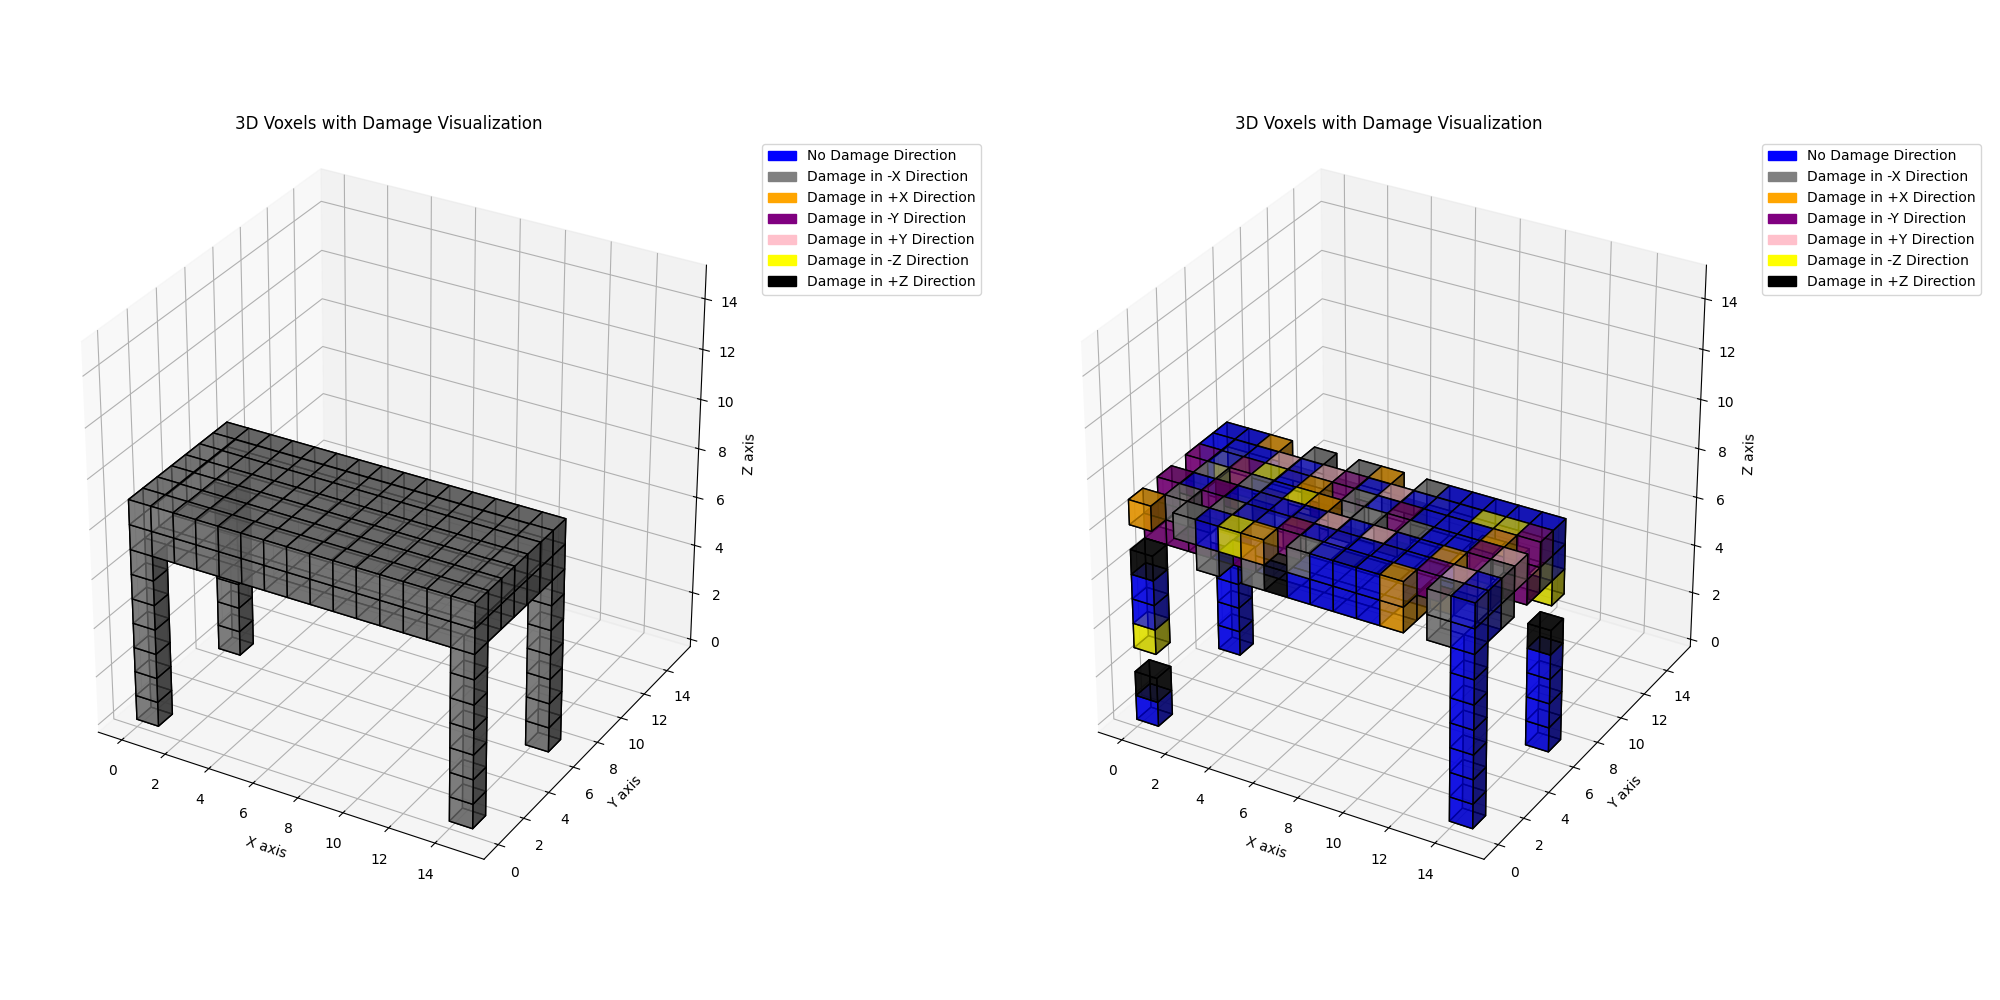

In [4]:
# Create two images
damage_mask_tensor, damage_direction_tensor, label, original_shape = dataset[7]
original_shape_img = plot_voxels(live_mask=original_shape.numpy().astype(np.uint8), damage_direction=original_shape.numpy().astype(np.uint8))
damage_img = plot_voxels(live_mask=damage_mask_tensor.numpy().astype(np.uint8), damage_direction=damage_direction_tensor.numpy().astype(np.uint8))

# Combine images side by side
from PIL import Image
combined_width = original_shape_img.width + damage_img.width
combined_height = max(original_shape_img.height, damage_img.height)
combined_img = Image.new('RGBA', (combined_width, combined_height))
combined_img.paste(original_shape_img, (0, 0))
combined_img.paste(damage_img, (original_shape_img.width, 0))

# Display the combined image
combined_img

#### Train

In [5]:
model = NCA3DDamageDetection()

In [ ]:
save_weights(model, 0)

=========================================================================== WEIGHTS ===========================================================================


#ifndef NEURAL_NET_H 
#define NEURAL_NET_H 
#include <Arduino.h> 
PROGMEM const float percieve_kernel_back[28][84]  = {{-0.016512666,-0.0034846778,0.025345305,-0.027709763,0.026975768,-0.0015978073,0.03064794,0.030399071,0.028071588,0.028176803,-0.027785538,0.0027217378,0.0067050657,-0.008278593,-0.033544928,0.03632959,-0.009878153,-0.02219927,0.02374419,0.00080278836,-0.00031145214,-0.014181821,-0.01866794,0.01630454,-0.010354063,0.006658827,-0.0061178477,0.019074818,0.022032365,0.018447757,-0.018663786,-0.010140881,-0.03005162,0.013425883,0.009047278,0.021318903,0.02515209,0.009542864,0.019559626,-0.019051922,-0.020255124,0.005409749,0.036122177,-0.0057726214,-0.026262723,-0.021270448,0.010160322,-0.03463756,0.006511035,-0.030610545,0.029400462,0.000107475185,-0.020632807,0.019374313,-0.0024364684,-0.0086528165,-0.030503035,

In [6]:
trainer = NCA3DTrainer(model, dataset, batch_size=1, lr=0.0001, iterations_per_epoch=100, steps_per_sample=96, buffer_size=1000, buffer_sampling_prob=0.5)

In [7]:
trainer.train(epochs=100, save_frequency=10, visualization_frequency=10)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shyamsn97. Use `wandb login --relogin` to force relogin


Epoch 0: 100%|██████████| 100/100 [00:35<00:00,  2.86it/s, loss=51.9059, acc=0.4658]


Epoch 0 - Train Loss: 51.9059, Accuracy: 0.00%, Time: 54.67s
(15, 15, 15)
(1, 15, 15, 15)
(1, 15, 15, 15)


Epoch 1: 100%|██████████| 100/100 [00:36<00:00,  2.73it/s, loss=4.0995, acc=0.7339]


Epoch 1 - Train Loss: 4.0995, Accuracy: 180.80%, Time: 53.22s


Epoch 2: 100%|██████████| 100/100 [00:31<00:00,  3.13it/s, loss=4.3806, acc=0.9615]


Epoch 2 - Train Loss: 4.3806, Accuracy: 4.80%, Time: 47.95s


Epoch 3: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s, loss=3.0076, acc=0.9648]


Epoch 3 - Train Loss: 3.0076, Accuracy: 0.00%, Time: 48.67s


Epoch 4: 100%|██████████| 100/100 [00:33<00:00,  2.96it/s, loss=3.8920, acc=0.6500]


Epoch 4 - Train Loss: 3.8920, Accuracy: 253.60%, Time: 51.64s


Epoch 5: 100%|██████████| 100/100 [00:39<00:00,  2.52it/s, loss=2.5981, acc=0.5769]


Epoch 5 - Train Loss: 2.5981, Accuracy: 53.60%, Time: 59.59s


Epoch 6: 100%|██████████| 100/100 [00:36<00:00,  2.71it/s, loss=2.3933, acc=0.9194]


Epoch 6 - Train Loss: 2.3933, Accuracy: 128.80%, Time: 54.46s


Epoch 7: 100%|██████████| 100/100 [00:33<00:00,  3.01it/s, loss=3.9761, acc=0.9265]


Epoch 7 - Train Loss: 3.9761, Accuracy: 280.00%, Time: 50.53s


Epoch 8: 100%|██████████| 100/100 [00:35<00:00,  2.79it/s, loss=1.9384, acc=0.2951]


Epoch 8 - Train Loss: 1.9384, Accuracy: 15.20%, Time: 53.35s


Epoch 9: 100%|██████████| 100/100 [00:33<00:00,  2.98it/s, loss=1.8666, acc=0.8909]


Epoch 9 - Train Loss: 1.8666, Accuracy: 80.00%, Time: 49.61s


Epoch 10: 100%|██████████| 100/100 [00:35<00:00,  2.81it/s, loss=1.9936, acc=0.8876]


Epoch 10 - Train Loss: 1.9936, Accuracy: 107.20%, Time: 60.10s
(15, 15, 15)
(1, 15, 15, 15)
(1, 15, 15, 15)


Epoch 11: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=0.9880, acc=0.9219]


Epoch 11 - Train Loss: 0.9880, Accuracy: 7.20%, Time: 77.51s


Epoch 12: 100%|██████████| 100/100 [00:45<00:00,  2.22it/s, loss=0.8683, acc=0.8950]


Epoch 12 - Train Loss: 0.8683, Accuracy: 33.60%, Time: 63.01s


Epoch 13: 100%|██████████| 100/100 [00:32<00:00,  3.08it/s, loss=0.7736, acc=0.8280]


Epoch 13 - Train Loss: 0.7736, Accuracy: 1.60%, Time: 50.32s


Epoch 14: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s, loss=0.7099, acc=0.5495]


Epoch 14 - Train Loss: 0.7099, Accuracy: 104.00%, Time: 47.54s


Epoch 15: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s, loss=0.7076, acc=0.9043]


Epoch 15 - Train Loss: 0.7076, Accuracy: 23.20%, Time: 50.16s


Epoch 16: 100%|██████████| 100/100 [00:31<00:00,  3.13it/s, loss=0.6272, acc=0.9208]


Epoch 16 - Train Loss: 0.6272, Accuracy: 0.80%, Time: 50.06s


Epoch 17: 100%|██████████| 100/100 [00:36<00:00,  2.74it/s, loss=0.5665, acc=0.9708]


KeyboardInterrupt: 